In [14]:
import numpy as np
import cv2
import os

import skimage
import skimage.io

from skimage.filters import threshold_otsu
from skimage.color import rgb2gray

import matplotlib.pyplot as plt

from skimage.morphology import remove_small_objects, binary_dilation, binary_closing, square, dilation, erosion, opening, closing, diameter_opening

In [2]:
FILES = !ls inputs/*

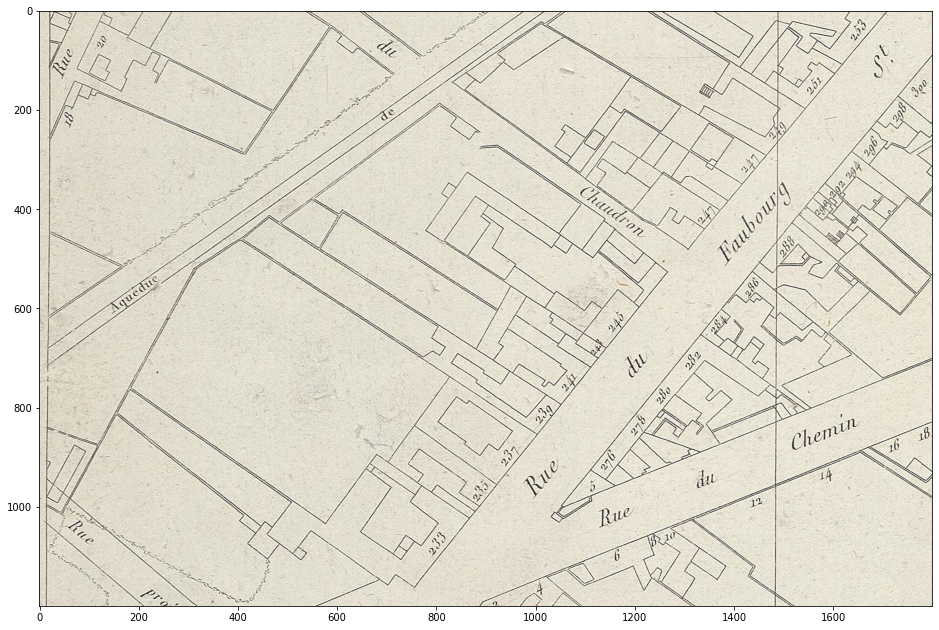

In [3]:
#image = skimage.io.imread(FILES[-1])
image = skimage.io.imread(FILES[3])[5000:6200, 200: 2000, :]
#image = skimage.io.imread(FILES[-1])[6200:7700, 4600: 6100, :]
# image = skimage.io.imread(FILES[2])[4000:5000, 2000:3000, :]

plt.figure(figsize=(16,16))
imgplot = plt.imshow(image,  cmap=plt.cm.gray)

In [4]:
denoised = rgb2gray(cv2.fastNlMeansDenoising(image))

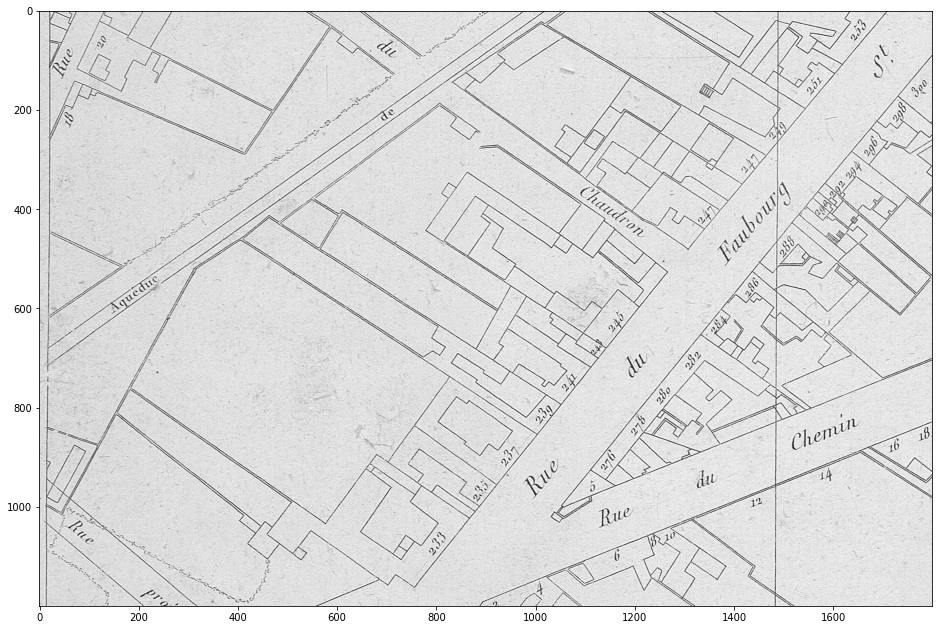

In [5]:
plt.figure(figsize=(16,16))
imgplot = plt.imshow(denoised,  cmap=plt.cm.gray)

In [6]:
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray

gray = 1 - denoised

gray2 = opening(gray, square(4))

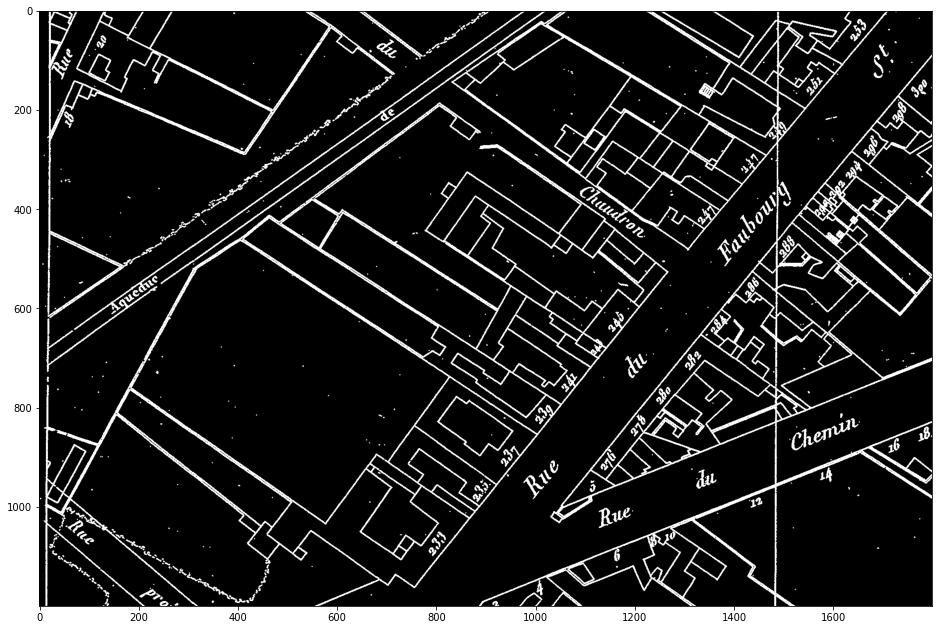

In [15]:
from skimage.filters import threshold_otsu

threshold = threshold_otsu(gray)
binary_otsu = binary_dilation(gray > threshold)

plt.figure(figsize=(16,16))
imgplot = plt.imshow(binary_otsu, cmap=plt.cm.gray)

<ipython-input-8-acfa4eff4232>:4: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  gray = 1 - rgb2gray(denoised)


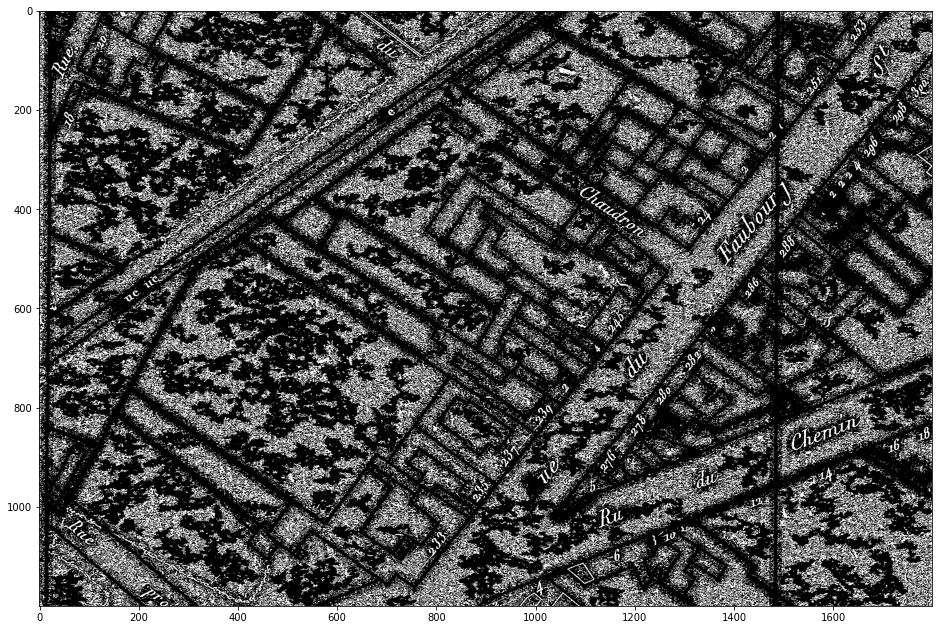

In [8]:
from skimage.filters import threshold_sauvola, inverse
from skimage.color import rgb2gray

gray = 1 - rgb2gray(denoised)

threshold = threshold_sauvola(gray, window_size=25, k=0.05)
binary = gray > threshold
binary = binary * 255 - remove_small_objects(binary, 400) * 255
binary = binary > 0

# binary = binary_closing(binary)
#binary = binary_closing(binary, square(3))

plt.figure(figsize=(16,16))
imgplot = plt.imshow(binary,  cmap=plt.cm.gray)
#threshold

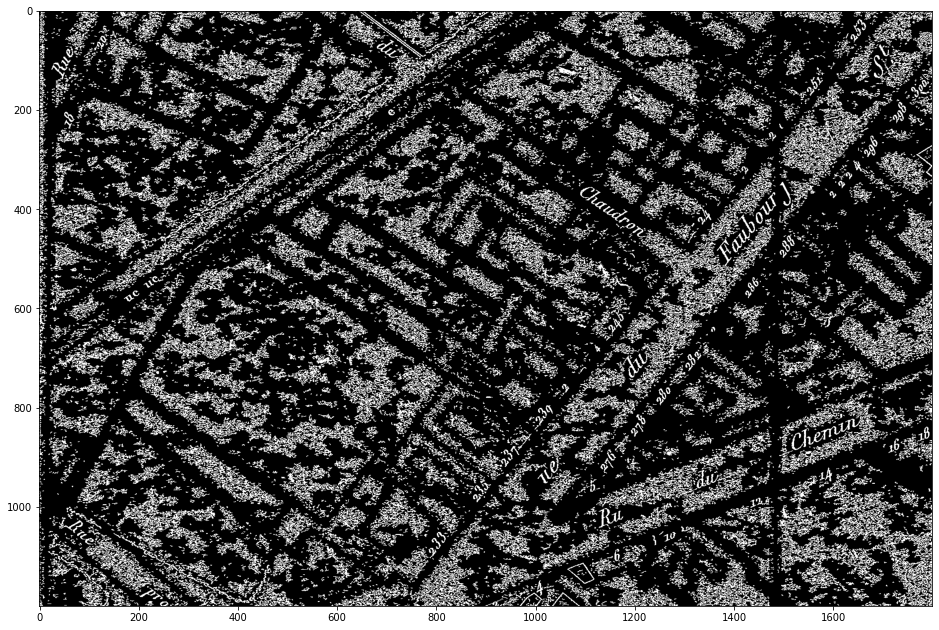

In [9]:
#binary = binary_closing(binary, square(3))
small = (remove_small_objects(binary, 5) * 255) - (remove_small_objects(binary, 400) * 255)

plt.figure(figsize=(16,16))
imgplot = plt.imshow(small,  cmap=plt.cm.gray)

In [23]:
from skimage.measure import label
from skimage.measure import regionprops

label_image = label(small)
images = []

for i, region in enumerate(regionprops(label_image)):
    bbox = region.bbox
    ratio = region.minor_axis_length / region.major_axis_length
    box = label_image[bbox[0]:bbox[2],bbox[1]:bbox[3]]
    
    if ratio < 0.25:
        sm = small[bbox[0]:bbox[2],bbox[1]:bbox[3]]
        sm[box == i + 1] = 0
        continue

    label = denoised[bbox[0]:bbox[2],bbox[1]:bbox[3]][box == i + 1]

    total_count = label.shape[0]
    black_count = np.sum(label <= 0.5)# - total_count / 3

    total_square_count = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
    active_square_count = np.sum(box == i + 1)

    if black_count / total_count < 0.1 or active_square_count / total_square_count < 0.2:
        sm = small[bbox[0]:bbox[2],bbox[1]:bbox[3]]
        sm[box == i + 1] = 0
        continue

    images.append(binary[bbox[0]:bbox[2],bbox[1]:bbox[3]])

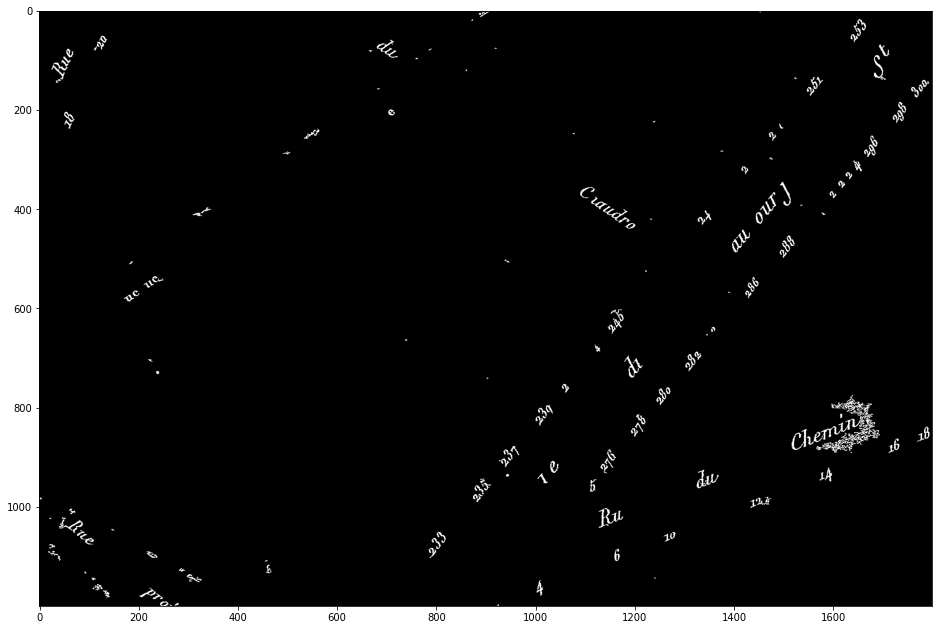

In [24]:
plt.figure(figsize=(16,16))
imgplot = plt.imshow(small,  cmap=plt.cm.gray)

In [25]:
skimage.io.imsave("small.png", small)
skimage.io.imsave("binary.png", binary)
skimage.io.imsave("gray.png", gray)

<ipython-input-25-ffdaa8767df1>:1: UserWarning: small.png is a low contrast image
  skimage.io.imsave("small.png", small)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-25-ffdaa8767df1>:2: UserWarning: binary.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  skimage.io.imsave("binary.png", binary)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


255


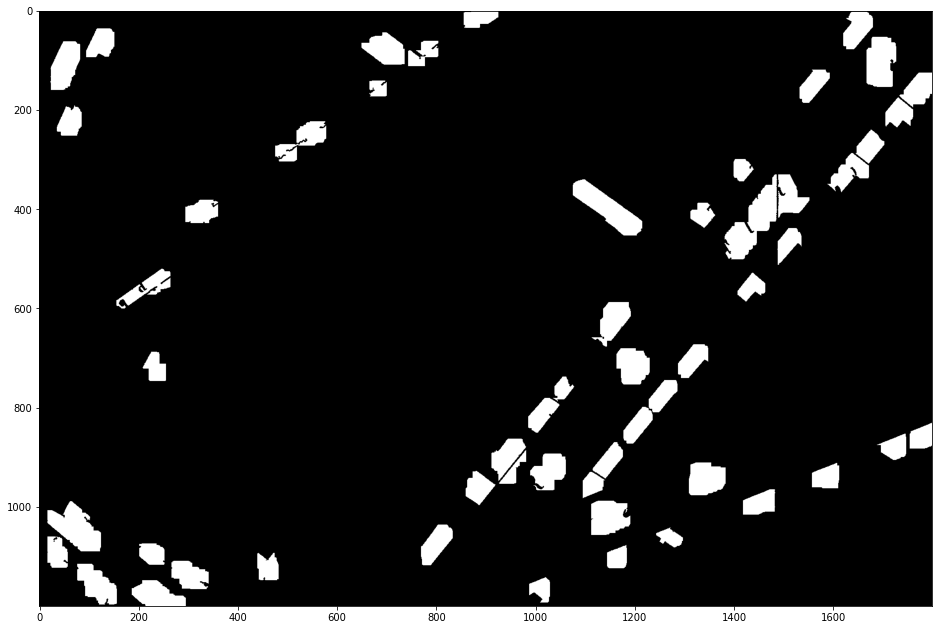

In [26]:
from skimage.morphology import *

closed_small = dilation(small, square(30))

im = (binary_otsu*255 - small) > 0
closed_small[im > 0] = False
closed_small = closed_small > 0
closed_small = remove_small_holes(closed_small, 1000)

closed_small = remove_small_objects(closed_small, 1000)*255 - remove_small_objects(closed_small, 10000)*255

print(np.max(small))
plt.figure(figsize=(16,16))
imgplot = plt.imshow(closed_small,  cmap=plt.cm.gray)

In [27]:
label_image = label(closed_small)

for i, region in enumerate(regionprops(label_image)):
    bbox = region.bbox
    box = label_image[bbox[0]:bbox[2],bbox[1]:bbox[3]]

    ratio = region.minor_axis_length / region.major_axis_length

    if ratio < 0.4:
        print("bye")
        sm = closed_small[bbox[0]:bbox[2],bbox[1]:bbox[3]]
        sm[box == i + 1] = 0

bye
bye
bye
bye
bye


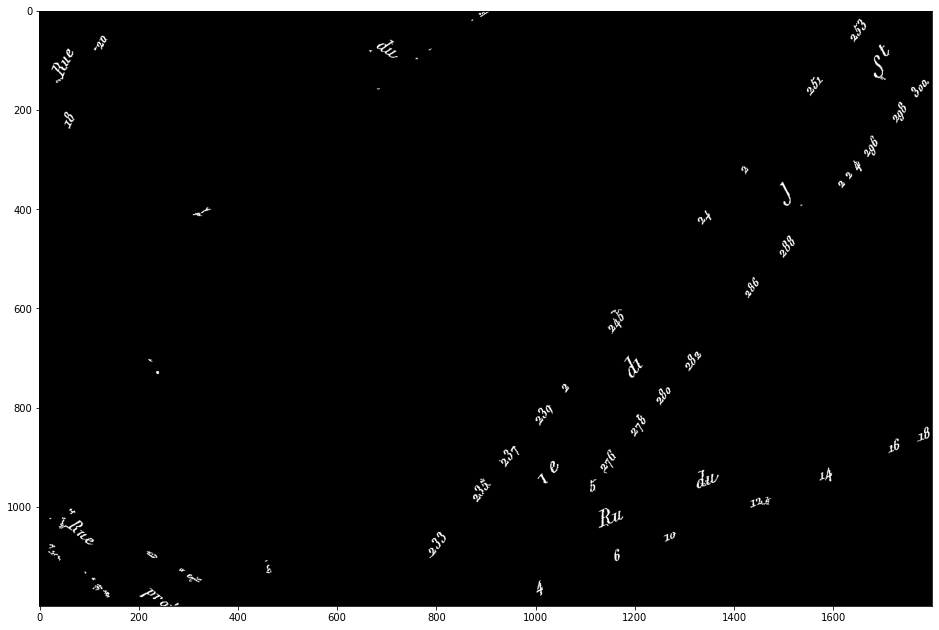

In [28]:
result = np.bitwise_and(closed_small > 0, small > 0)
plt.figure(figsize=(16,16))
imgplot = plt.imshow(result, cmap=plt.cm.gray)